Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [35]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Ud\
acity/DeepLearning-Udacity' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified /media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large.tar.gz
Found and verified /media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large already present - Skipping extraction of /media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large.tar.gz.
['/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large/A', '/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large/B', '/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large/C', '/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large/D', '/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large/E', '/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large/F', '/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/Deep

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
#Code written by LDP
#Display images from each class(directory)

number_sample_images = 10 #Number of images to be exposed from each class

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
classes_size = len(classes)

for i in range(0, classes_size):
    path_to_image = 'notMNIST_large/' + classes[i]
    image_names = os.listdir(path_to_image)
    image_names_size = len(image_names)
    for j in range(0, number_sample_images):
        #It exists a chance that an image to be taken twice
        nr_image = np.random.randint(0, image_names_size)
        print(image_names[nr_image])
        image = Image(path_to_image + '/' + image_names[nr_image])
        display(image)



VlRDIE5pZ2h0T2ZUaGVXYWNrZWREZWFkLnR0Zg==.png


RGFpbHlOZXdzLUJvbGQub3Rm.png


QnVsbGV0czMucGZi.png


R2lsbFNhbnNTaGFkb3dNVFN0ZC5vdGY=.png


Rm9ybWF0YSBCb2xkIENvbmRlbnNlZC50dGY=.png


TmljayBUdXJibyBJdGFsaWMudHRm.png


RFRMRG9jdW1lbnRhU2Fuc1NULUl0YWxpYy5vdGY=.png


R29sZHN0b25lIFJlZ3VsYXIudHRm.png


QXJnb3N5IEV4cGFuZGVkLnR0Zg==.png


TGltZXJpY2stUmVndWxhckNvbmRJdGEub3Rm.png


Q29ybmVyU3RvbmUub3Rm.png


SW5rcGFkIFJlZ3VsYXIudHRm.png


Q3JlbW9uYUV4cGVydEJRLUJvbGRPc0Yub3Rm.png


S2hhcm5vcnJpYy50dGY=.png


QWlyIE1pbGxob3VzZSBJdGFsaWMudHRm.png


Q2hhbGV0LUxvbmRvbk5pbmV0ZWVuRWlnaHR5LnBmYg==.png


Um91bmRlc3QtWGxpZ2h0Lm90Zg==.png


SW50ZXJuYXRpb25hbCBTdXBlciBIZXJvIExpZ2h0LnR0Zg==.png


QWt6aWRlbnogR3JvdGVzayBCbGFjay50dGY=.png


SHVtYW5pc3QgNTIxIExpZ2h0IEl0YWxpYy5wZmI=.png


Y2VyaXBoIDA1XzU1LnR0Zg==.png


RnV0dXJhQlEtTGlnaHRPYmxpcXVlLm90Zg==.png


U0YgV2FzYWJpIENvbmRlbnNlZCBJdGFsaWMudHRm.png


UmVsYXlXaWRlLUJsYWNrLnR0Zg==.png


dW50aXRsZWQzLnR0Zg==.png


Q29wcGVycGxhdGUgR290aGljIEhlYXZ5IEJULnR0Zg==.png


Q2l0eS1NZWRpdW0ub3Rm.png


TWFycXVpc2V0dGUgQlROIEJvbGQudHRm.png


Um95YWx0b25DbmQtTm9ybWFsLnR0Zg==.png


QmlvbmljIENvbWljLnR0Zg==.png


VHdDZW5NVFN0ZC1FeHRyYUJvbGRDb25kLm90Zg==.png


SW9sbm92YS1NZWRpdW0ub3Rm.png


Q29tcGF0aWxUZXh0IExUIEJvbGQgU21hbGwgQ2Fwcy50dGY=.png


SG9iYnkgQ29uZGVuc2VkIEl0YWxpYy50dGY=.png


RWdpemlhbm9DbGFzc2ljLVNoYWRvd09MLm90Zg==.png


QmVybGluZ0xUU3RkLUJvbGQub3Rm.png


QmVsbWFyRXh0T2JsLU5vLnR0Zg==.png


UG9ldGljYVN0ZC5vdGY=.png


TmV3cyBHb3RoaWMgTVQgSXRhbGljLnR0Zg==.png


T3Jib25JVENTdGQtQmxhY2sub3Rm.png


SHVycmljYW5lLnR0Zg==.png


QWJzdHJha3QudHRm.png


U2hha2V5U2xhYnNlcmlmLnR0Zg==.png


U2FtU2Fucy1UaGluLm90Zg==.png


QnJpZW1Ba2FkZW1pU3RkLVNlbWlib2xkQ24ub3Rm.png


QmVuamFtaW4gR290aGljIEhlYXZ5LnR0Zg==.png


VHJhbmNlZm9ybS50dGY=.png


QmVydGhvbGRJbWFnb0JRLUV4dHJhQm9sZEl0YWxpYy5vdGY=.png


WGNlbHNpb24gU2hhZG93IEl0YWxpYy50dGY=.png


TEhGIERlZiBBcnRpc3QgQkFTRS50dGY=.png


WnVyaWNoIFdpbjk1QlQoMSkudHRm.png


VmljdG9yaWFuRC50dGY=.png


U0YgV29uZGVyIENvbWljIEJsb3RjaCBJdGFsaWMudHRm.png


V2V0IFBldC50dGY=.png


TW9kZXJuMjBCVC1JdGFsaWNCLm90Zg==.png


Q2luYWhhbmQgRGluZ2JhdHMudHRm.png


U2Fmcm9sZSBPYmxpcXVlLnR0Zg==.png


RnV0dXJhSUNHLVhCb2xkT2JsaXF1ZS5vdGY=.png


SWNvbHVrdS1SZWd1bGFyLm90Zg==.png


TW9zdGx5V2F2ZXMgUmVndWxhci50dGY=.png


Q2FydHdyaWdodC50dGY=.png


Um9tYW5TY3JpcHRFRi1BbHRlcm5hdGUub3Rm.png


VmFtcGlyZXNzLnR0Zg==.png


VW5pdmVyc0xUU3RkLU9ibC5vdGY=.png


S3JvZWdlcjA2NjUudHRm.png


V2Fsa3dheSBFeHBhbmQgQmxhY2sudHRm.png


RXhwZWwgTm9ybWFsLnR0Zg==.png


TWFsYWhpdCBCb2xkLnR0Zg==.png


TW9vbkRhbmNlVHdvLnR0Zg==.png


VGluc25pcHMub3Rm.png


TVdhbGJhdW0ub3Rm.png


Q2FmZXRlcmlhLUJvbGQub3Rm.png


RmFybmhhbVRleHQtUmVndWxhckl0YWwub3Rm.png


U0YgU3BlZWR3YXlzdGFyLnR0Zg==.png


UmVsYXlDb21wLUxpZ2h0LnR0Zg==.png


VXRvcGlhLUJvbGRJdGFsaWNPc0Yub3Rm.png


RGVsdGFJdGFsaWMudHRm.png


RkZGIEJ1c2luZXNzIEJvbGQudHRm.png


TWV0YUJsYWNrQ3lyTEYtSXRhbGljLm90Zg==.png


SHVtYW5hIFNhbnMgTWQgSVRDIFRUIE1lZGl1bUl0YS50dGY=.png


RGZDYWxsaWdyYXBoaWNPcm5hbWVudHNQbGFpbi5wZmI=.png


SmVzc2ljYSBPYmxpcXVlLnR0Zg==.png


S2FiZWxJdGNURUVEZW0udHRm.png


VGVtcGxldHQgQ29uZGVuc2VkIEl0YWxpYy50dGY=.png


QW1lcmljYW5UeXBld3JpdGVyU3RkLUJvbGQub3Rm.png


UHJpbWEgU2FucyBCb2xkIEJULnR0Zg==.png


V2lsaGVsbUtsaW5nc3BvckdvdGlzY2ggRXgudHRm.png


TWFudXNjcmlwdC1FeHRlbmRlZCBOb3JtYWwudHRm.png


Qk4gTW9vZyBCb3kudHRm.png


RmxvcmFsZXNzLnR0Zg==.png


Qm91Z2FuIEJsYWNrIFNTaSBFeHRyYSBCb2xkLnR0Zg==.png


SW50cmVwaWQgQm9sZC50dGY=.png


Q29ycG9yYXRlQUV4cGVydEJRLUxpZ2h0Lm90Zg==.png


SG9mZm1hbm4tQm9sZC5vdGY=.png


VGlmZmFueSBIZWF2eSBJdGFsaWMgQlQudHRm.png


QXV0bzItTGlnaHRMRi50dGY=.png


R2VueCBLQ29uZCBDeXIudHRm.png


UHJpbmNldG9uIHNvbGlkIENvbmRlbnNlZCBJdGFsaWMudHRm.png


TGV2aWF0aGFuLUhURi1CbGFjay5vdGY=.png


R291ZHlTYW5zSVRDYnlCVC1CbGFja0l0YWxpYy5vdGY=.png


We want to keep data in memory to access it more quickly.
Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try: #data here is normalized
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle' #pickle file = python object serialization
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large/A.pickle already present - Skipping pickling.
/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large/B.pickle already present - Skipping pickling.
/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large/C.pickle already present - Skipping pickling.
/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large/D.pickle already present - Skipping pickling.
/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large/E.pickle already present - Skipping pickling.
/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/DeepLearning-Udacity/notMNIST_large/F.pickle already present - Skipping pickling.
/media/ldp/5EB82447B8241FCF/Daniela/Scoală/Cursuri/DeepLearning-Udacity/Deep

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

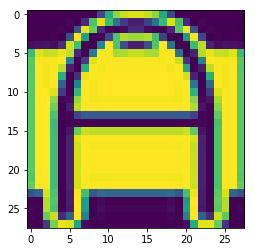

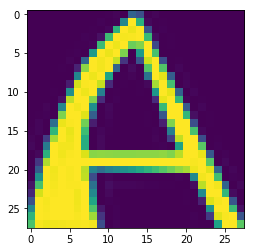

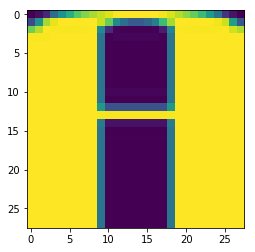

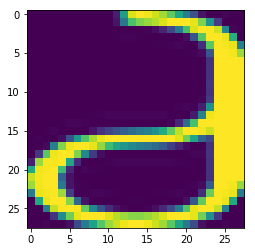

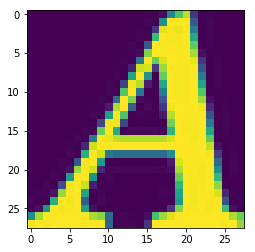

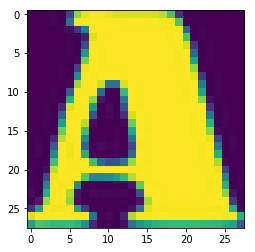

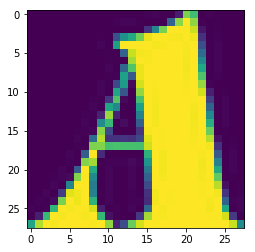

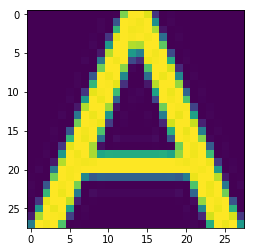

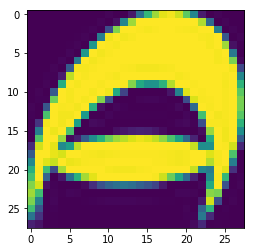

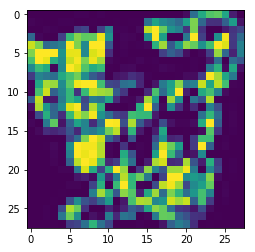

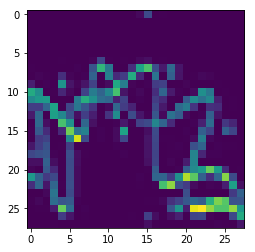

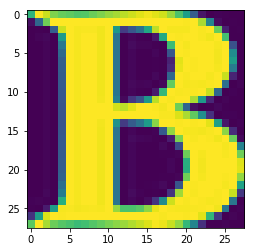

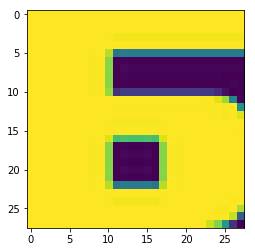

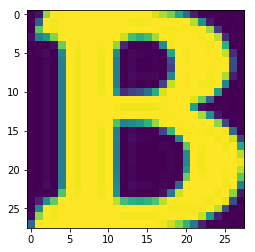

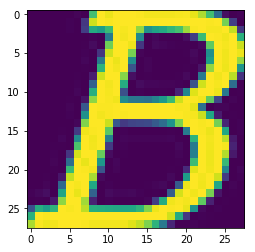

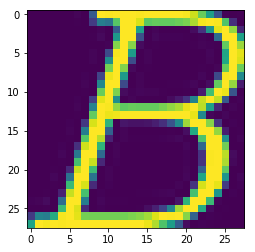

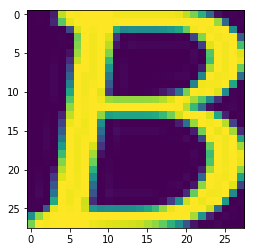

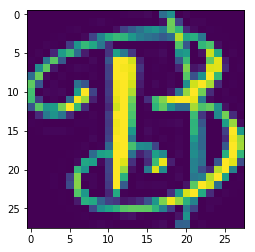

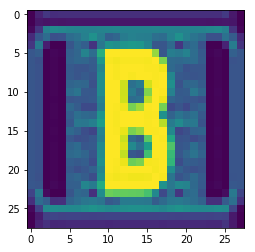

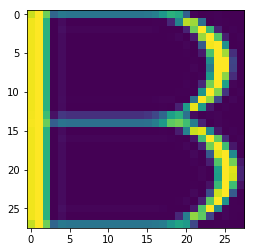

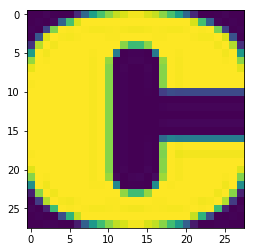

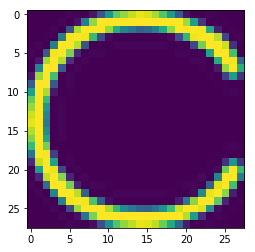

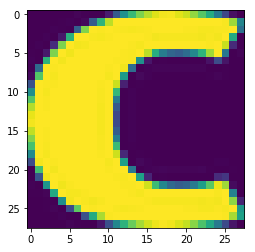

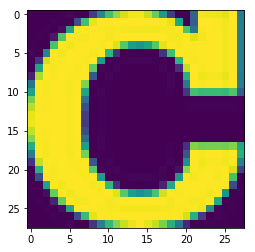

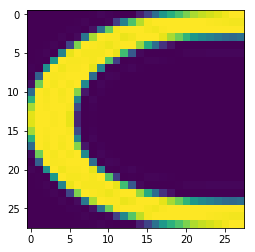

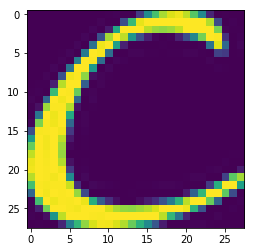

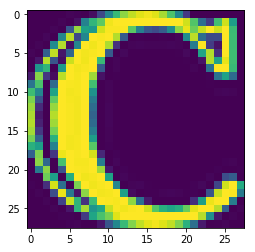

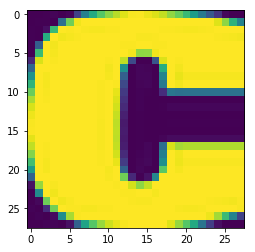

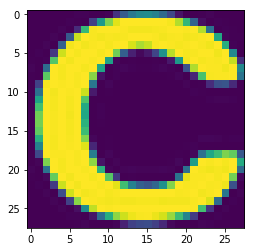

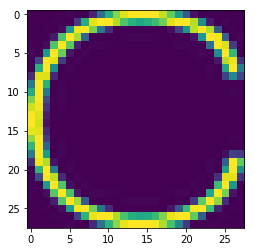

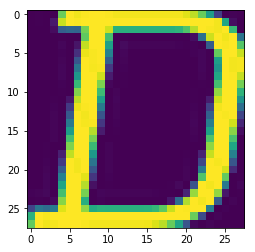

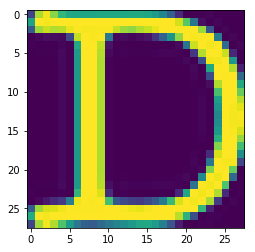

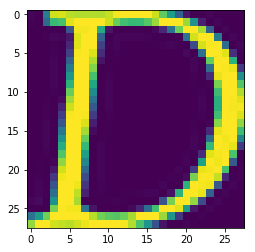

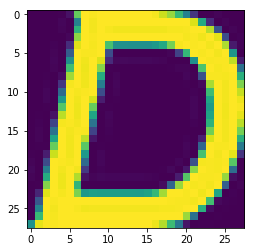

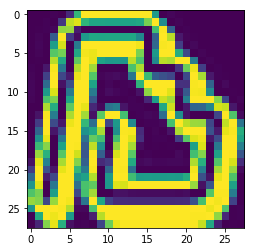

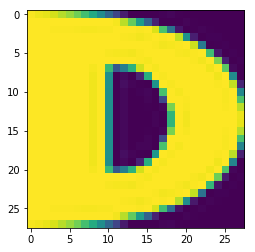

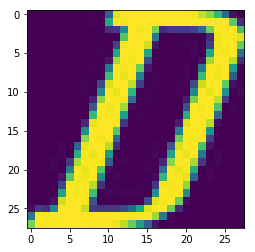

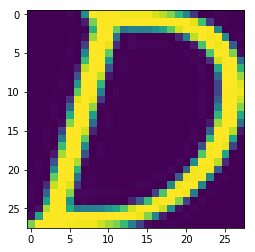

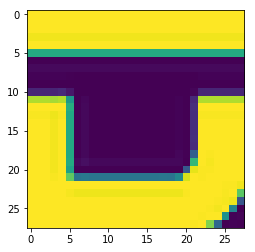

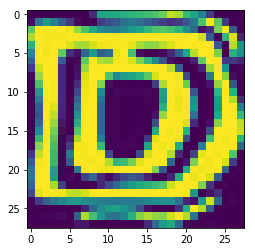

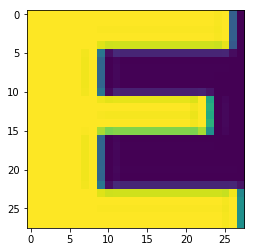

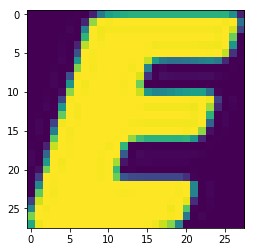

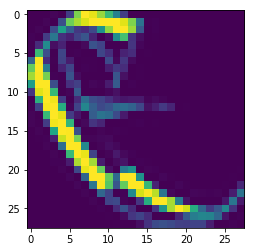

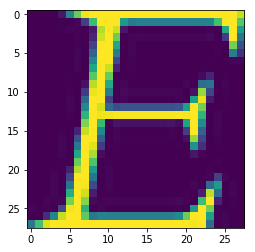

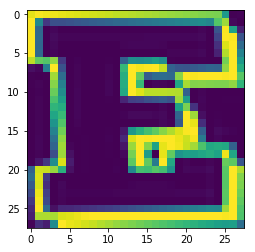

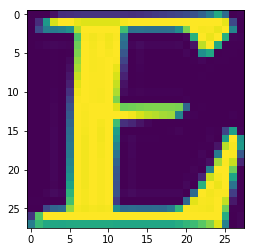

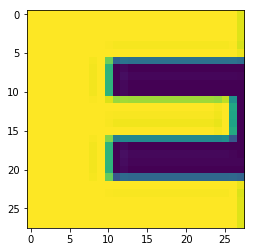

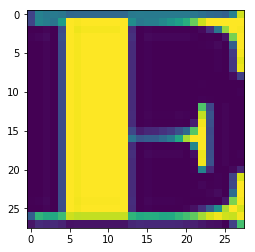

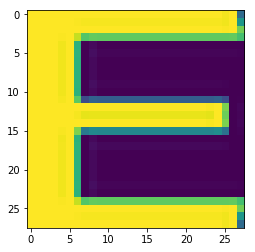

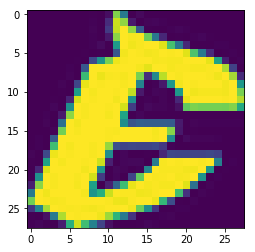

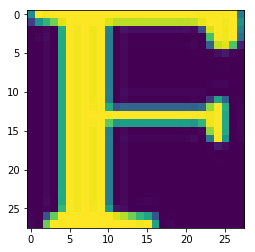

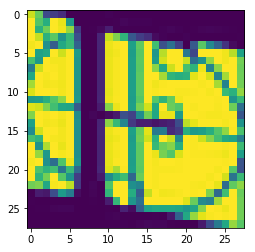

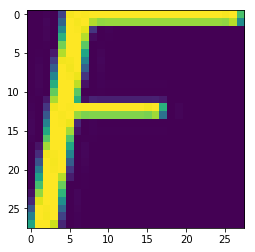

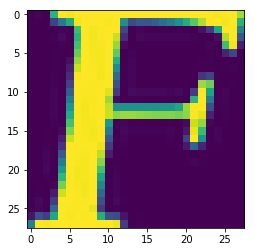

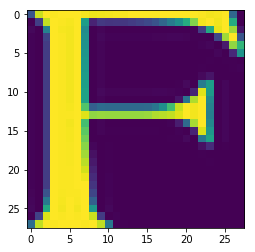

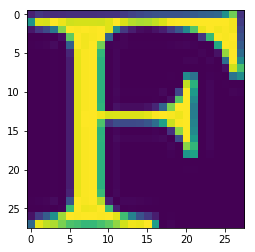

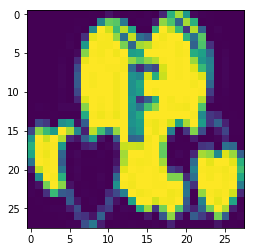

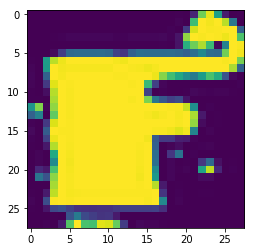

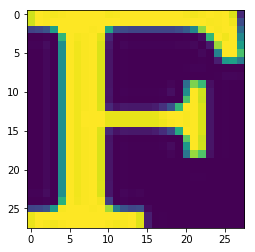

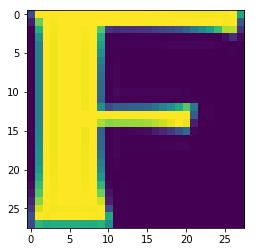

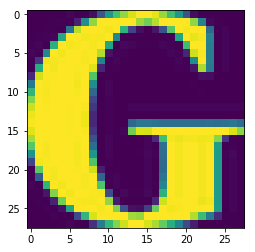

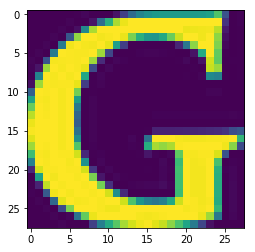

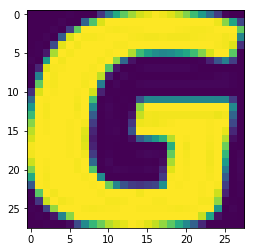

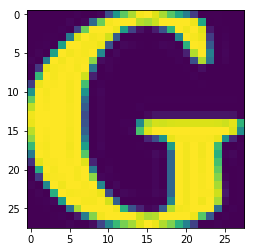

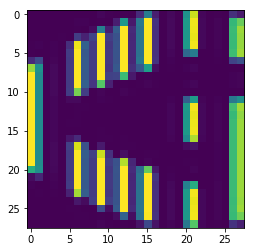

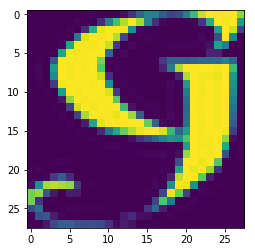

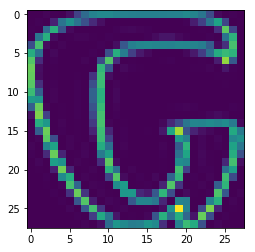

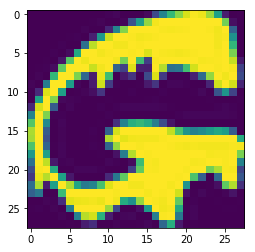

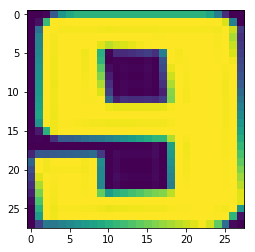

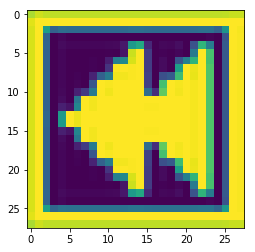

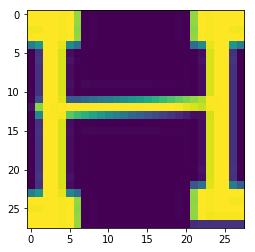

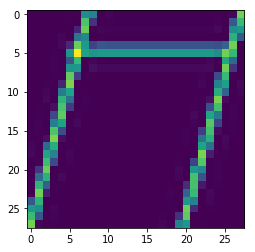

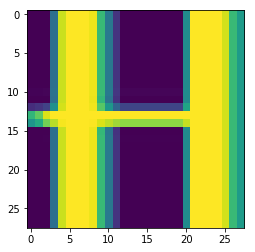

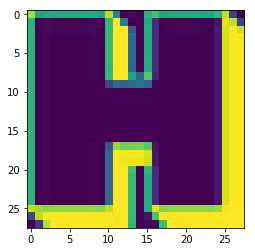

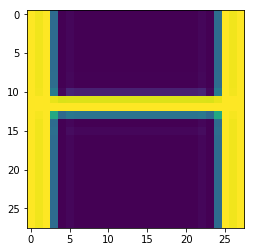

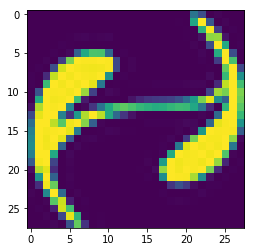

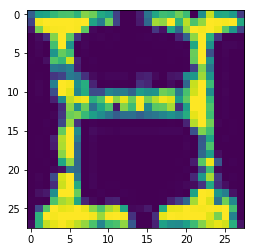

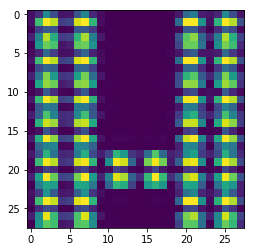

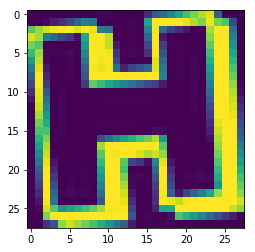

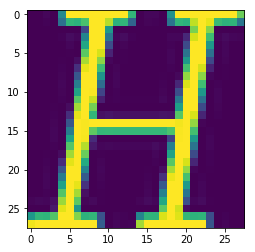

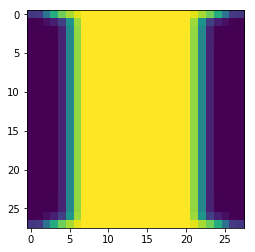

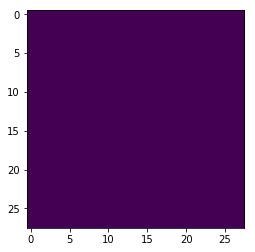

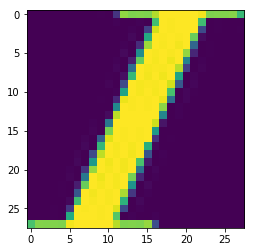

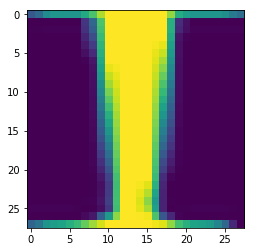

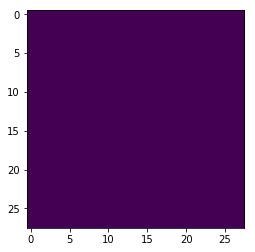

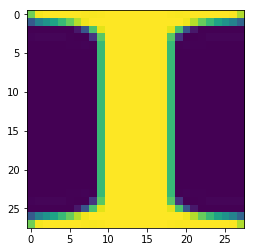

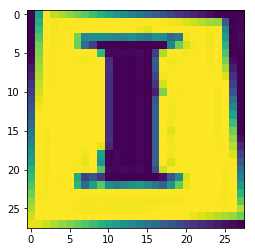

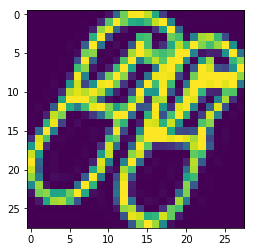

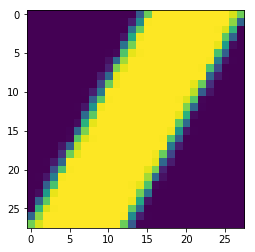

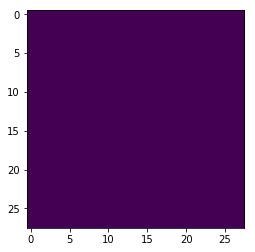

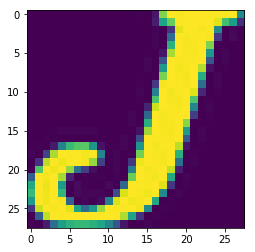

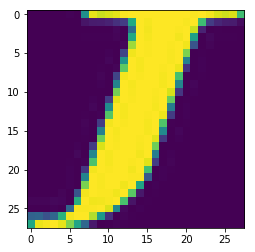

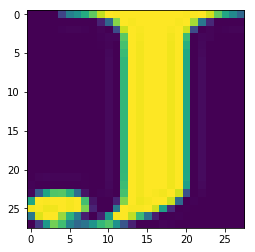

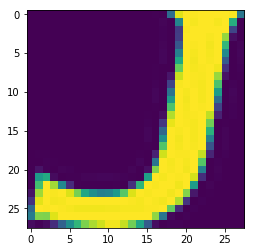

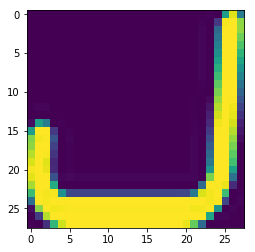

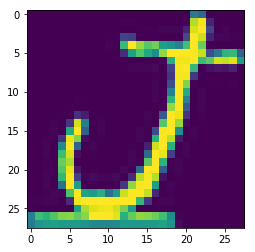

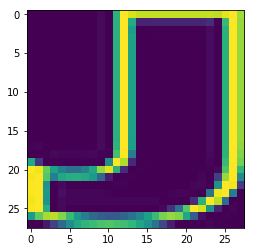

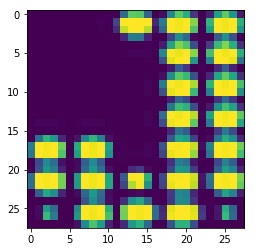

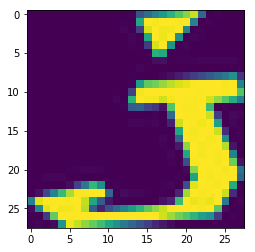

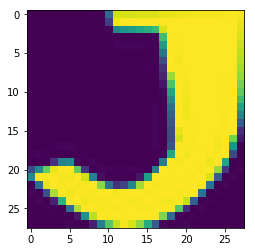

In [6]:
#Code written by LDP
#Display images from each class(directory)

number_sample_images = 10 #Number of images to be exposed from each class

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
classes_size = len(classes)

number_of_examples = []

for i in range(0, classes_size):
    #deserialization of file in order to plot the image
    pkl_file = open('notMNIST_large/' + classes[i] + '.pickle','rb')
    images_data = pickle.load(pkl_file)
    for j in range(0, number_sample_images):
        #It exists a chance that an image to be taken twice
        nr_image = np.random.randint(0, image_names_size)
        plt.imshow(images_data[nr_image], interpolation='nearest')
        plt.show()
    #create a tuple with the number of images from each class
    number_of_examples.append((classes[i],len(images_data)))
    

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [7]:
#Code written by LDP

#print the number of examples from each class
for i in range(0, len(number_of_examples)):
    print("Class " + str(number_of_examples[i][0]) + " has " + str(number_of_examples[i][1]) + " examples.")
    

Class A has 52909 examples.
Class B has 52911 examples.
Class C has 52912 examples.
Class D has 52911 examples.
Class E has 52912 examples.
Class F has 52912 examples.
Class G has 52912 examples.
Class H has 52912 examples.
Class I has 52912 examples.
Class J has 52911 examples.


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 10000
valid_size = 2500
test_size = 2500

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (10000, 28, 28) (10000,)
Validation: (2500, 28, 28) (2500,)
Testing: (2500, 28, 28) (2500,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Examples from dataset: 0
Label(Class) 1


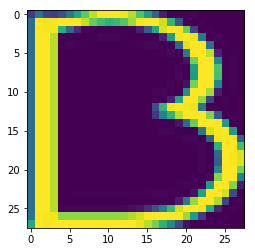

Label(Class) 0


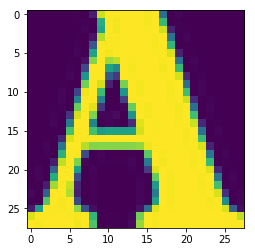

Label(Class) 7


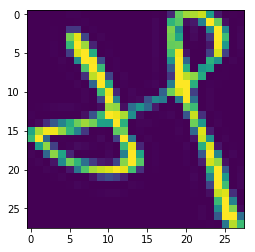

Label(Class) 4


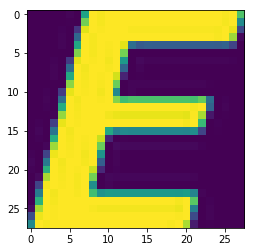

Label(Class) 2


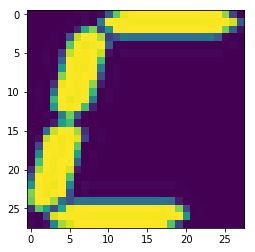

Label(Class) 1


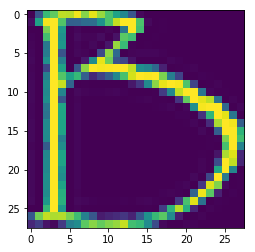

Label(Class) 0


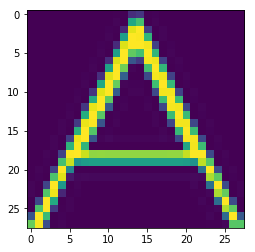

Label(Class) 3


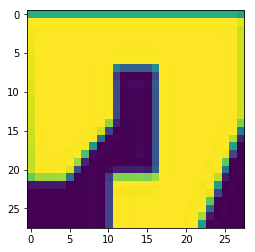

Label(Class) 6


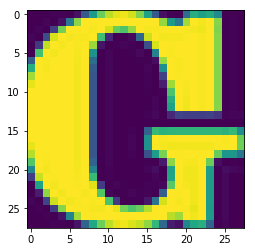

Label(Class) 6


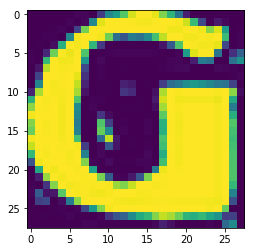

Examples from dataset: 1
Label(Class) 5


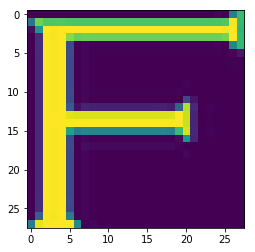

Label(Class) 6


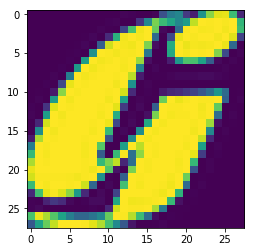

Label(Class) 2


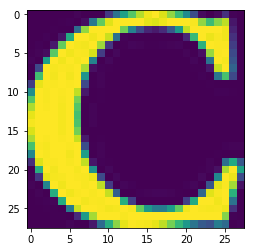

Label(Class) 7


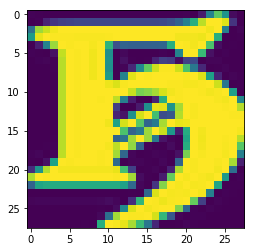

Label(Class) 6


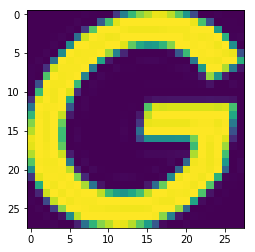

Label(Class) 1


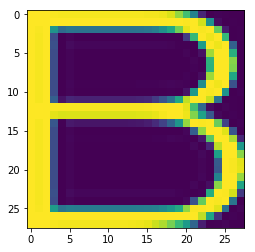

Label(Class) 0


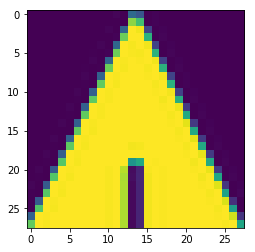

Label(Class) 2


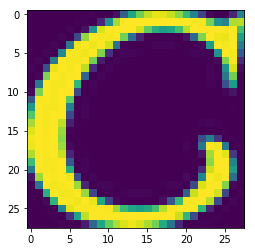

Label(Class) 1


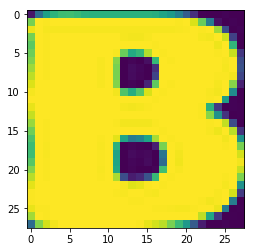

Label(Class) 0


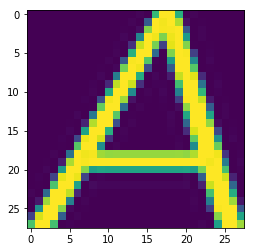

Examples from dataset: 2
Label(Class) 8


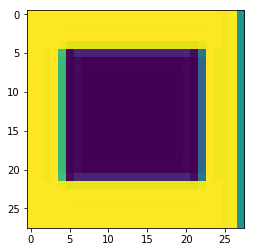

Label(Class) 9


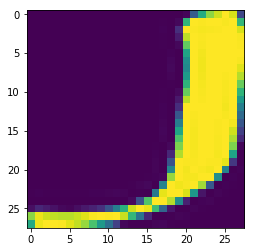

Label(Class) 6


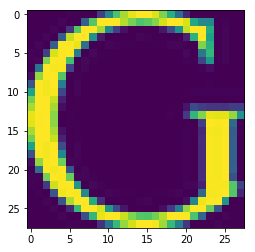

Label(Class) 3


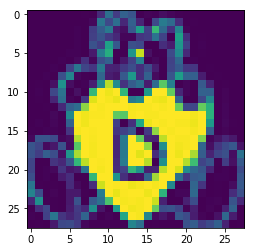

Label(Class) 0


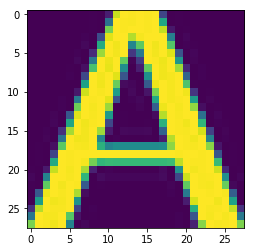

Label(Class) 9


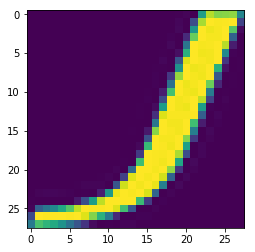

Label(Class) 4


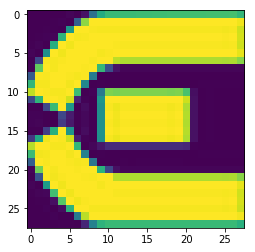

Label(Class) 3


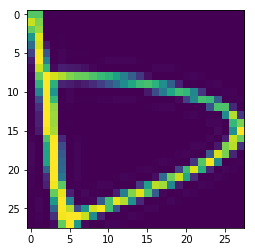

Label(Class) 2


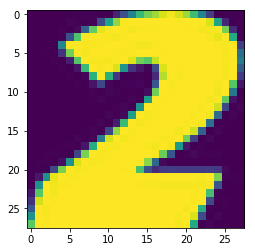

Label(Class) 6


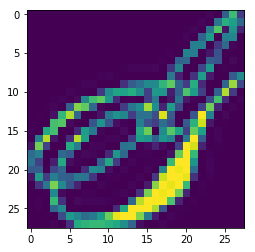

In [10]:
#Code written by LDP

nr_images = 10
dataset_to_see = [train_dataset, test_dataset, valid_dataset]
label_to_see = [train_labels, test_labels, valid_labels]

for i in range(0, len(dataset_to_see)):
    print("Examples from dataset: " + str(i))
    for j in range(0, nr_images):
        #It exists a chance that an image to be taken twice
        nr_image = np.random.randint(0, len(dataset_to_see[i]))
        print("Label(Class) " + str(label_to_see[i][nr_image]))
        plt.imshow(dataset_to_see[i][nr_image], interpolation='nearest')
        plt.show()
    

Finally, let's save the data for later reuse:

In [11]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb') #we keep the data in a dictionary
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [12]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 47100490


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [13]:
#Code written by LDP

counter_valid = 0
counter_test = 0

#compare the ndarrays
for i in range(0, len(train_dataset)):
    print(str(i))
    for j in range(0, len(valid_dataset)):
        if (np.array_equal(train_dataset[i], valid_dataset[j])):
            counter_valid = counter_valid + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339


6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981


8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620


In [14]:
for i in range(0, len(train_dataset)):
    print(str(i))
    for j in range(0, len(test_dataset)):
        if (np.array_equal(train_dataset[i], test_dataset[j])):
            counter_test = counter_test + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070


3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712


5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362


6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012


8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662


In [15]:
print(counter_valid)
procent = (counter_valid / len(valid_dataset)) * 100
print("The percentage of examples which are also in the train_dataset and valid_dataset")
print(procent)

3142
The percentage of examples which are also in the train_dataset and valid_dataset
125.67999999999999


In [16]:
print(counter_test)
procent = (counter_test / len(test_dataset)) * 100
print("The percentage of examples which are also in the train_dataset and valid_dataset")
print(procent)

3610
The percentage of examples which are also in the train_dataset and valid_dataset
144.4


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [17]:
#Code written by LDP

logistic_regr = LogisticRegression()

#https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
nsamples, nx, ny = train_dataset.shape
d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))

nsamples, nx, ny = test_dataset.shape
d2_test_dataset = test_dataset.reshape((nsamples,nx*ny))


logistic_regr.fit(d2_train_dataset, train_labels)

predictions = logistic_regr.predict(d2_test_dataset)

score = logistic_regr.score(d2_test_dataset, test_labels)
print(score*100)



86.72


In [34]:
#Code written by LDP
#Cross validation

pipeline = Pipeline([
           ("estimator", LogisticRegression(multi_class="multinomial", solver="lbfgs"))
])

np.mean(cross_val_score(pipeline, d2_train_dataset, train_labels, scoring="accuracy", cv=10))

0.7878000000000001